In [1]:
import os

import numpy as np
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt
import pandas as pd
from toolsets.file_io import get_file_list, readin_peak_list
import toolsets.spectra_operations as so
from toolsets.std_list_prep import complete_smiles, complete_mono_mass, complete_formal_charge, guess_adduct, std_list_cleanup
from toolsets.ff_droup import process_mzml, get_EIC_list, EIC, feature_finding
from toolsets.search import string_search,quick_search_values
from tqdm import tqdm
from molmass import Formula
from toolsets.sirius_lite import mass_to_formula, check_chemistry, get_isotope, ms1_intensity_score, bin_ms1
from toolsets.spectra_plotter import ms2_plot, head_to_tail_plot
import seaborn as sns
import matplotlib.pyplot as plt
from toolsets.std_list_prep import calculate_precursormz
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi'
peak_list_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi/peak_list'
from toolsets.constants import single_charged_adduct_mass

In [272]:
std_list = pd.read_csv(os.path.join(master_dir, 'casmi_std_list.csv'))
from toolsets.API_gets import inchi_to_smiles
std_list
smiles = []
for index, row in tqdm(std_list.iterrows(), total = len(std_list)):
    smiles_temp = inchi_to_smiles(row['InChIKey'])
    smiles.append(smiles_temp)
std_list['SMILES']=smiles
    # break
std_list.dropna(subset=['SMILES'], inplace=True)
from toolsets.std_list_prep import check_mol

#

100%|██████████| 500/500 [09:48<00:00,  1.18s/it]


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcExactMolWt(float)
did not match C++ signature:
    CalcExactMolWt(RDKit::ROMol mol, bool onlyHeavy=False)

In [274]:
pos_adduct =['[M+H]+', '[M+NH4]+', '[M+Na]+']
neg_adduct = ['[M-H]-', '[M+FA-H]-', '[M+Cl]-']
adduct_all = pos_adduct+neg_adduct
std_list_raw = std_list.copy()
for adduct in adduct_all:
    cur_adduct_lst = []
    for index, row in std_list.iterrows():

        if row[adduct]>0.00001:
            cur_adduct_lst.append(calculate_precursormz(row['SMILES'], adduct))
        else:
            cur_adduct_lst.append(0)
    std_list[adduct]=cur_adduct_lst

In [127]:
# from toolsets.sirius_lite import mass_to_formula, get_isotope, compare_iso_pattern
# std_raw = pd.read_csv(os.path.join(master_dir, 'casmi_std_list.csv'))
# from toolsets.API_gets import inchi_to_smiles
#
# smiles = []
# for index, row in tqdm(std_raw.iterrows(), total = len(std_raw)):
#     smiles_temp = inchi_to_smiles(row['InChIKey'])
#     smiles.append(smiles_temp)
# std_raw['smiles']=smiles
# std_raw.drop(['SMILES'], axis=1, inplace=True)
# std_raw['smiles']=smiles
# std_raw.dropna(subset=['smiles'], inplace =True)
# from toolsets.std_list_prep import neutrilize_salt_df
# std_list_neu = neutrilize_salt_df(std_raw, smile_column='smiles')
# mono_mass = []
# for index, row in std_list_neu.iterrows():
#     mol_temp = Chem.MolFromSmiles(row['smiles'])
#     mono_mass.append(CalcExactMolWt(mol_temp))
# std_list = pd.read_csv(os.path.join(master_dir, 'std_list_cleaned.csv'))
#
# std_list.to_csv(os.path.join(master_dir, 'std_list_cleaned.csv'), index = True)
# from time import time
# start = time()
# candidate = mass_to_formula(482.251583, 0.002)
# end = time()
# print((end-start)/60)
# chemistry_result = []
# for c in candidate:
#     chemistry_result.append(check_chemistry(c))
# res = [i for i, val in enumerate(chemistry_result) if val]
#
# candidate_valid = [Formula(candidate[r]).formula for r in res]
# iso_patterns = []
# for c in candidate_valid:
#     iso_patterns.append(get_isotope(c))
# iso_score = []
# for iso_pattern in iso_patterns:
#     iso_score.append(compare_iso_pattern(iso1, iso_pattern))
# result = pd.DataFrame(zip(candidate_valid, iso_patterns, iso_score), columns=['candidate_formula', 'simulated_iso', 'iso_score'])
# from toolsets.constants import single_charged_adduct_mass
# adduct_cols = [x for x in std_list.columns if x in single_charged_adduct_mass.keys()]
# mode = []
# reference_adduct = []
# for index, row in std_list.iterrows():
#     data_temp = row[adduct_cols]
#     reference_adduct.append(adduct_cols[np.argmax(data_temp.values)])
#     mode.append(adduct_cols[np.argmax(data_temp.values)][-1])
#     # break
# std_list.insert(3, 'reference_adduct', reference_adduct)
# std_list.insert(4, 'mode', mode)
# std_list.to_csv(os.path.join(master_dir, 'std_list_cleaned.csv'), index = False)

In [280]:
adduct_cols = [x for x in std_list.columns if x in single_charged_adduct_mass.keys()]
mode = []
reference_adduct = []
for index, row in std_list.iterrows():
    data_temp = row[adduct_cols]
    reference_adduct.append(adduct_cols[np.argmax(data_temp.values)])
    mode.append(adduct_cols[np.argmax(data_temp.values)][-1])
    # break
std_list.insert(3, 'reference_adduct', reference_adduct)
std_list.insert(4, 'mode', mode)
std_list.to_csv(os.path.join(master_dir, 'std_list_cleaned.csv'), index = False)

In [281]:
std_list

,InChIKey,SMILES,Formula,reference_adduct,mode,Exact Mass,Mix label,RT [min],PRECURSORMZ,Adduct,Priority/Bonus,[M+H]+,[M+NH4]+,[M+Na]+,[M-H]-,[M+FA-H]-,[M+Cl]-
0,ZUDBDCBPZHGAEL-DCYCNZAJSA-N,CC12CC(CC(C1CCC34C2CCC(C3)C(=C)C4O)C(=O)O)OC5C...,C25H38O9,[M+Cl]-,-,482.251570,A_M28_negPFP_04,1.67,517.2210,[M+Cl]-,Priority,0.000000,0.0,0.000000,0.000000,0.000000,517.220985
1,ZKCHQVRAXCCTLE-YXHZOQBQSA-N,CC1(C2CCC3(C(C2(CCC1OC4C(C(C(CO4)OC5C(C(C(C(O5...,C46H74O18,[M+FA-H]-,-,914.487490,A_M8_negPFP_03,3.70,959.4857,[M+FA-H]-,Priority,0.000000,0.0,0.000000,0.000000,959.485716,0.000000
2,UYALDZZEAZIEME-MYTBKXFISA-N,CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC...,C35H42O16,[M+H]+,+,718.247273,A_M3_posPFP_01,5.55,719.2546,[M+H]+,Priority,719.254561,0.0,0.000000,0.000000,0.000000,0.000000
3,IFQVIMQHTPDZQU-UHFFFAOYSA-N,CC(C)CC(C(=O)O)NC(=O)C(C(C)C)OC(=O)C(C(C)C)NC(...,C22H40N2O7,[M+Na]+,+,444.283537,A_M6_posPFP_02,5.74,467.2728,[M+Na]+,Priority,0.000000,0.0,467.272770,0.000000,0.000000,0.000000
4,XPXRFYSHQGUVFK-UTXMSIPTSA-N,CC1CC2(C(C1O)C=C(C(CC3C(C3(C)C)C=C(C2=O)C)OC(=...,C26H36O8,[M+Na]+,+,476.241006,A_M23_posPFP_02,5.55,499.2302,[M+Na]+,Priority,0.000000,0.0,499.230236,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CQXZVXNVRFIVCN-UHFFFAOYSA-N,CC(CC(CC1=CC2=CC(=CC(=C2C(=O)O1)O)O)O)O,C14H16O6,[M-H]-,-,280.094684,A_M15_negPFP_03,2.56,279.0874,[M-H]-,Bonus,0.000000,0.0,0.000000,279.087412,0.000000,0.000000
496,HELVNAROXHFAIE-WRJJPCEFSA-N,CC1C(C(C(C(O1)OC2C(C(OC(C2O)OC3C(CC4(C(C3(C)CO...,C48H76O20,[M-H]-,-,972.492970,A_M19_negPFP_03,4.42,971.4857,[M-H]-,Bonus,0.000000,0.0,0.000000,971.485719,0.000000,0.000000
497,SNXYIHBATNUFDM-UHFFFAOYSA-N,CC1=CC(=C(C2=C1C(=O)OC3=C(O2)C(=C(C(=C3)C(=O)O...,C17H14O8,[M-H]-,-,346.068864,A_M13_negPFP_03,5.65,345.0616,[M-H]-,Bonus,0.000000,0.0,0.000000,345.061591,0.000000,0.000000
498,XUDCXSSDAZIAPT-IFVSHKQPSA-N,C1=CC(=CC=C1C2C(C(=O)C3=C(C=C(C=C3O2)O)O)C4=C(...,C36H30O16,[M-H]-,-,718.153378,A_M2_negPFP_03,3.41,717.1461,[M-H]-,Bonus,0.000000,0.0,0.000000,717.146109,0.000000,0.000000


In [286]:
std_list_pos = std_list[std_list['mode']=='+']
std_list_neg = std_list[std_list['mode']=='-']

In [181]:
from toolsets.precursor_matching import find_adduct_columns
from toolsets.feature_alignment import find_feature
def precursor_matching_peaklist(std_list_mix, pl_temp):
    pl_temp = pl_temp[['RT (min)','Precursor m/z', 'Height', 'Isotope','MS1 isotopes', 'MSMS spectrum']]
    adducts =find_adduct_columns(std_list_mix.columns)
    matched_mix = pd.DataFrame()
    raw_mix = pd.DataFrame()
    reference_columns = [col for col in std_list_mix.columns if col not in adducts]
    reference_adduct = []
    reference_precursor_mz=[]
    for index, row in std_list_mix.iterrows():
        for adduct in adducts:
            # print(row[adduct])

            raw_matched = find_feature(pl_temp, mz = row[adduct], rt = row['RT [min]'], mz_column = 'Precursor m/z', rt_column = 'RT (min)', rt_offset=10)

            if len(raw_matched)>0:   #there is at least 1 valid match
                # raw_matched.sort_values(by = 'ms1_intensity', inplace=True, ascending= False)
                matched_mix= matched_mix.append([pd.DataFrame([row[reference_columns]])], ignore_index=True)
                raw_matched.sort_values(by = 'Height', ascending=False, inplace = True)
                raw_mix= pd.concat([raw_mix, pd.DataFrame([raw_matched.iloc[0]])],ignore_index=True)
                reference_adduct.extend([adduct])
                reference_precursor_mz.extend([row[adduct]])
    matched_mix.columns = ['reference_'+col_name for col_name in matched_mix.columns]
    matched_mix['reference_adduct']= reference_adduct
    matched_mix['reference_precursor_mz']=reference_precursor_mz
    matched_mix_spec = pd.concat([matched_mix, raw_mix], axis=1)

    if len(matched_mix_spec)>0:

        # matched_mix_spec['mz_offset'] = abs(matched_mix_spec['Precursor m/z']-matched_mix_spec['reference_precursor_mz'])
        recovery_percent = len(set(matched_mix_spec['reference_InChIKey']))/len(set(std_list_mix['InChIKey']))*100
        matched_mix_spec['recovery_percent(%)']=recovery_percent
    # matched_mix_spec.insert(2, 'conc', np.repeat(conc, len(matched_mix_spec)))
    # matched_mix_spec.insert(3, 'ce', np.repeat(ce, len(matched_mix_spec)))
    return(matched_mix_spec)
def precursor_matching_all( pl_dir, std_list):
    from toolsets.file_io import readin_peak_list
    pl_list = get_file_list(pl_dir, '.txt', with_tail=False)
    matched = pd.DataFrame()
    for item in tqdm(pl_list):
        pl_temp = readin_peak_list(os.path.join(pl_dir, item+'.txt'))
        mix = item
        std_list_temp = string_search(std_list, 'Mix label', mix)
        matched_temp = precursor_matching_peaklist(std_list_temp, pl_temp)
        matched = pd.concat([matched, matched_temp], ignore_index=True)
    return(matched)

In [282]:
pos_pl_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi/peak_list/pos'
neg_pl_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi/peak_list/neg'

In [287]:
pos_matched = precursor_matching_all('/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi/peak_list/pos',std_list_pos)
neg_matched = precursor_matching_all('/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi/peak_list/neg',std_list_neg)

100%|██████████| 55/55 [00:09<00:00,  5.93it/s]


In [288]:
len(pos_matched)+len(neg_matched)

499

In [289]:
matched_all = pd.concat([pos_matched, neg_matched], ignore_index=True, axis=0)

In [292]:
matched_all.dropna(subset=['MSMS spectrum'], inplace=True)

In [293]:
matched_all.to_csv(os.path.join(master_dir, 'matched_all.csv'), index = False)

# below starts with matched all

In [2]:
matched_all = pd.read_csv(os.path.join(master_dir, 'matched_all.csv'))

In [5]:
matched_all.head()

,reference_InChIKey,reference_SMILES,reference_Formula,reference_reference_adduct,reference_mode,reference_Exact Mass,reference_Mix label,reference_RT [min],reference_PRECURSORMZ,reference_Adduct,reference_Priority/Bonus,reference_adduct,reference_precursor_mz,RT (min),Precursor m/z,Height,Isotope,MS1 isotopes,MSMS spectrum,recovery_percent(%)
0,ZNBQWPMZFPFCKS-GOSISDBHSA-N,CC1=CC(=O)OC1CC=C(C)CCC=C(CCC=C(C)C)C(=O)O,C20H28O4,[M+H]+,+,332.198749,A_M25_posPFP_01,5.82,333.2060,[M+H]+,Priority,[M+H]+,333.206035,5.827558,333.2054,76873248.0,M + 0,333.09335:326036 333.18277:354689 333.18729:41...,55.05476:20929 67.05432:74555 67.79105:12292 6...,100.0
1,OFDBBWUQAHAKDG-PREJITOJSA-N,CCC(C)C=C(C)C=CC(=O)OC1C=CC2=CC(=O)C(CC2(C1C)C...,C25H32O6,[M+H]+,+,428.219877,A_M25_posPFP_01,5.95,429.2272,[M+H]+,Priority,[M+H]+,429.227165,5.954288,429.2266,14719142.0,M + 0,429.06912:29183 429.19177:96403 429.22659:1643...,68.35921:2126 81.06982:5006 95.88636:2433 98.6...,100.0
2,PCWPSOCJBMEHGK-BZKLREMRSA-N,COC1=C(C=CC(=C1)CC(CO)C(CC2=CC(=C(C=C2)OC3C(C(...,C26H36O11,[M+NH4]+,+,524.225751,A_M25_posPFP_01,1.83,542.2596,[M+NH4]+,Priority,[M+NH4]+,542.259585,1.830238,542.2593,9319463.0,M + 0,542.02716:15122 542.25934:9664572 543.26257:28...,53.03874:2645 56.15794:2305 66.04675:3360 69.0...,100.0
3,IESDYJUGZCFEQG-UHFFFAOYSA-N,CCCCCC(CC(CC(=O)OC(CCCCC)CC(CC(=O)OC(CCCCC)CC(...,C49H88O25,[M+NH4]+,+,1076.561440,A_M25_posPFP_01,5.57,1094.5953,[M+NH4]+,Priority,[M+NH4]+,1094.595291,5.579183,1094.5930,11165936.0,M + 0,1094.59338:12613862 1095.59656:7457614 1096.59...,81.06976:36853 83.04905:9646 91.7446:4565 93.0...,100.0
4,FBMYKMYQHCBIGU-UHFFFAOYSA-N,CC(C)(CC1=CNC2=CC=CC=C21)NCC(COC3=CC=CC=C3C#N)O,C22H25N3O2,[M+Na]+,+,363.194667,E_M41_posPFP_02,5.91,386.1839,[M+Na]+,Priority,[M+Na]+,386.183895,5.913771,386.1831,15280335.0,M + 0,386.18314:19353618 386.19788:218962 387.18658:...,70.06512:4728 74.06:28168 86.11314:2601 96.541...,100.0


In [7]:
ms1 = []
msms = []
for index, row in matched_all.iterrows():
    ms1.append(so.convert_msdial_to_string(row['MS1 isotopes']))
    msms.append(so.convert_msdial_to_string(row['MSMS spectrum']))
matched_all['ms1']=ms1
matched_all['msms']=msms

In [8]:
from toolsets.file_io import export_mgf_sirius

In [9]:
mgf_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/casmi/mgfs'

In [11]:
matched_all

,reference_InChIKey,reference_SMILES,reference_Formula,reference_reference_adduct,reference_mode,reference_Exact Mass,reference_Mix label,reference_RT [min],reference_PRECURSORMZ,reference_Adduct,...,reference_precursor_mz,RT (min),Precursor m/z,Height,Isotope,MS1 isotopes,MSMS spectrum,recovery_percent(%),ms1,msms
0,ZNBQWPMZFPFCKS-GOSISDBHSA-N,CC1=CC(=O)OC1CC=C(C)CCC=C(CCC=C(C)C)C(=O)O,C20H28O4,[M+H]+,+,332.198749,A_M25_posPFP_01,5.82,333.2060,[M+H]+,...,333.206035,5.827558,333.2054,76873248.00,M + 0,333.09335:326036 333.18277:354689 333.18729:41...,55.05476:20929 67.05432:74555 67.79105:12292 6...,100.0,333.09335\t326036\n333.18277\t354689\n333.1872...,55.05476\t20929\n67.05432\t74555\n67.79105\t12...
1,OFDBBWUQAHAKDG-PREJITOJSA-N,CCC(C)C=C(C)C=CC(=O)OC1C=CC2=CC(=O)C(CC2(C1C)C...,C25H32O6,[M+H]+,+,428.219877,A_M25_posPFP_01,5.95,429.2272,[M+H]+,...,429.227165,5.954288,429.2266,14719142.00,M + 0,429.06912:29183 429.19177:96403 429.22659:1643...,68.35921:2126 81.06982:5006 95.88636:2433 98.6...,100.0,429.06912\t29183\n429.19177\t96403\n429.22659\...,68.35921\t2126\n81.06982\t5006\n95.88636\t2433...
2,PCWPSOCJBMEHGK-BZKLREMRSA-N,COC1=C(C=CC(=C1)CC(CO)C(CC2=CC(=C(C=C2)OC3C(C(...,C26H36O11,[M+NH4]+,+,524.225751,A_M25_posPFP_01,1.83,542.2596,[M+NH4]+,...,542.259585,1.830238,542.2593,9319463.00,M + 0,542.02716:15122 542.25934:9664572 543.26257:28...,53.03874:2645 56.15794:2305 66.04675:3360 69.0...,100.0,542.02716\t15122\n542.25934\t9664572\n543.2625...,53.03874\t2645\n56.15794\t2305\n66.04675\t3360...
3,IESDYJUGZCFEQG-UHFFFAOYSA-N,CCCCCC(CC(CC(=O)OC(CCCCC)CC(CC(=O)OC(CCCCC)CC(...,C49H88O25,[M+NH4]+,+,1076.561440,A_M25_posPFP_01,5.57,1094.5953,[M+NH4]+,...,1094.595291,5.579183,1094.5930,11165936.00,M + 0,1094.59338:12613862 1095.59656:7457614 1096.59...,81.06976:36853 83.04905:9646 91.7446:4565 93.0...,100.0,1094.59338\t12613862\n1095.59656\t7457614\n109...,81.06976\t36853\n83.04905\t9646\n91.7446\t4565...
4,FBMYKMYQHCBIGU-UHFFFAOYSA-N,CC(C)(CC1=CNC2=CC=CC=C21)NCC(COC3=CC=CC=C3C#N)O,C22H25N3O2,[M+Na]+,+,363.194667,E_M41_posPFP_02,5.91,386.1839,[M+Na]+,...,386.183895,5.913771,386.1831,15280335.00,M + 0,386.18314:19353618 386.19788:218962 387.18658:...,70.06512:4728 74.06:28168 86.11314:2601 96.541...,100.0,386.18314\t19353618\n386.19788\t218962\n387.18...,70.06512\t4728\n74.06\t28168\n86.11314\t2601\n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,KMEIZYNJCUTZNU-STDVHTBBSA-N,CC1(CCC2(CCC3(C(=CCC4C3(CCC5C4(CCC(C5(C)C)OC6C...,C53H86O22,[M+FA-H]-,-,1074.561046,A_M12_negPFP_03,5.21,1119.5593,[M+FA-H]-,...,1119.559275,5.206748,1119.5580,13976276.00,M + 0,1119.48291:41779 1119.55811:15216021 1119.7005...,83.01244:48052 85.02271:8351 85.02812:238909 8...,100.0,1119.48291\t41779\n1119.55811\t15216021\n1119....,83.01244\t48052\n85.02271\t8351\n85.02812\t238...
476,MTICHQXHYUJVDV-FGZJIHLKSA-N,CC1C2C(C(C(O1)OC3C(C(COC3OC(=O)C45CCC(CC4C6=CC...,C64H100O31,[M+FA-H]-,-,1364.624825,A_M12_negPFP_03,4.49,1409.6231,[M+FA-H]-,...,1409.623057,4.492421,1409.6220,3463948.25,M + 0,1409.62195:3559828 1409.70032:20099 1410.12219...,202.35123:26153 202.37289:19077 205.05244:1135...,100.0,1409.62195\t3559828\n1409.70032\t20099\n1410.1...,202.35123\t26153\n202.37289\t19077\n205.05244\...
477,UIYWFOZZIZEEKJ-XVFCMESISA-N,C1=CN(C(=O)NC1=O)C2C(C(C(O2)CO)O)F,C9H11FN2O5,[M+FA-H]-,-,246.065197,E_M28_negPFP_03,0.33,291.0634,[M+FA-H]-,...,291.063401,0.233251,291.0628,9933765.00,M + 0,291.03287:48300 291.06284:10539934 291.1506:45...,53.24164:2001 56.26165:8375 59.0126:15874 65.9...,100.0,291.03287\t48300\n291.06284\t10539934\n291.150...,53.24164\t2001\n56.26165\t8375\n59.0126\t15874...
478,IFBHRQDFSNCLOZ-IIRVCBMXSA-N,C1=CC(=CC=C1[N+](=O)[O-])OC2C(C(C(C(O2)CO)O)O)O,C12H15NO8,[M+FA-H]-,-,301.079763,E_M28_negPFP_03,0.94,346.0780,[M+FA-H]-,...,346.077967,0.942491,346.0771,9879360.00,M + 0,345.96417:30970 346.03836:11760 346.0527:76291...,52.69771:2559 53.98551:2539 58.60519:2669 59.0...,100.0,345.96417\t30970\n346.03836\t11760

In [13]:
for index, row in tqdm(matched_all.iterrows(), total = len(matched_all)):
    export_mgf_sirius(row, mgf_dir)

100%|██████████| 480/480 [00:00<00:00, 7328.67it/s]


# Below are 7 goledn rule part

In [213]:
n_total = []
n_viable = []
for i in tqdm(range(150, 500)):
    formulas_all= mass_to_formula(i, 0.005)
    formula_viable = [x for x in formulas_all if check_chemistry(x)]
    n_total.append(len(formulas_all))
    n_viable.append(len(formula_viable))
    # break

100%|██████████| 350/350 [2:18:38<00:00, 23.77s/it]  


In [217]:
np.max(n_viable)

18288

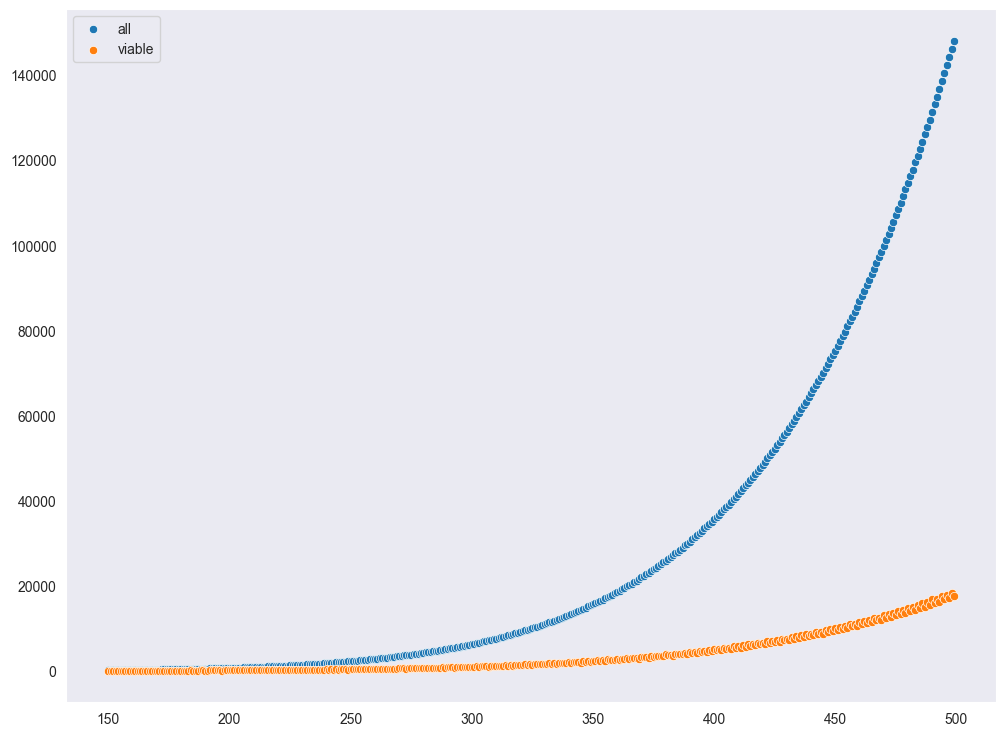

In [216]:
fig = plt.figure(figsize = (12, 9))#43
ax = fig.add_subplot()
#
sns.scatterplot(x = range(150, 500),y = n_total, label = 'all')
sns.scatterplot(x = range(150, 500),y = n_viable, label = 'viable')
# sns.lineplot(x = range(1,14), y = ns_means)
# sns.histplot(library_bad_quality['normalized_entropy'], label = 'low_quality')
# plt.vlines(x = 0.8, ymin=0, ymax=1.8, color = 'red')
plt.grid(False)
plt.legend()

In [209]:
formula_viable = [x for x in formulas_all if check_chemistry(x)==True]